Import libraries

In [2]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import distance_transform_edt
import tifffile
from tensorflow.keras.callbacks import ModelCheckpoint

2025-04-02 10:00:01.052466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 10:00:01.060347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 10:00:01.062798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Set the input paths and parameters

In [2]:
train_input_path = "/home/khietdang/Documents/khiet/treeRing/tile_big_dis/train/x"
train_mask_path = "/home/khietdang/Documents/khiet/treeRing/tile_big_dis/train/y"
test_input_path = "/home/khietdang/Documents/khiet/treeRing/tile_big_dis/test/x"
test_mask_path = "/home/khietdang/Documents/khiet/treeRing/tile_big_dis/test/y"
model_path = "/home/khietdang/Documents/khiet/tree-ring-analyzer/src/models"

Get the paths of the images and masks

In [3]:

print("---")
test_input_paths = [os.path.join(test_input_path, path) for path in os.listdir(test_input_path) if path.endswith(".tif")]
test_mask_paths = [os.path.join(test_mask_path, path) for path in os.listdir(test_mask_path) if path.endswith(".tif")]
print("Test images: " + str(len(test_input_paths)))
print("Test masks: " + str(len(test_mask_paths)))
test_path_dataset = tf.data.Dataset.from_tensor_slices((test_input_paths, test_mask_paths))
type(test_path_dataset)


---
Test images: 2653
Test masks: 2653


I0000 00:00:1743580805.677402   16741 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743580805.697410   16741 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743580805.697522   16741 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743580805.700500   16741 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

We define a function to read image/mask pairs.

In [4]:
from tree_ring_analyzer.dl.train import read_images, Training

Normalize images and masks.

We create a dataset containing pairs of images/masks.

In [5]:

test_dataset = test_path_dataset.map(lambda img_path, label: (read_images(img_path, label)), num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
train = Training(train_input_path, train_mask_path)
train_dataset = train.trainDataset
data = train_dataset.take(1)
print(type(train_dataset))
print(data)


<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None))>


Trying to compensate for class imbalance.

Build train and validation batches.

In [12]:
BATCH_SIZE = 8
BUFFER_SIZE = 512
VALIDATION_SIZE = int(round((len(train_dataset) * 20) / 100))
print("validation data size: " + str(VALIDATION_SIZE))
print("train data size: " + str(len(train_dataset) - VALIDATION_SIZE))
validation_batches = train_dataset.take(VALIDATION_SIZE).batch(BATCH_SIZE)
train_batches = train_dataset.skip(VALIDATION_SIZE)
train_batches = train_batches.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


validation data size: 2155
train data size: 8620


In [12]:
train_dataset.take(1)
print(type(train_dataset))

<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>


In [13]:
data = train_dataset.take(1)
mask = data.get_single_element()[1]
mask

<tf.Tensor: shape=(256, 256, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

Display some random examples of pairs of input tiles and mask tiles.

(256, 256, 3)
(256, 256, 1)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.1882353, shape=(), dtype=float32)
tf.Tensor(12.1640625, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


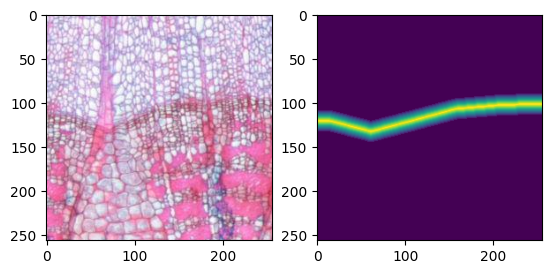

(256, 256, 3)
(256, 256, 1)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.16078432, shape=(), dtype=float32)
tf.Tensor(12.1640625, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


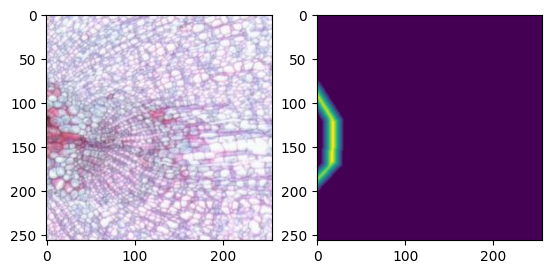

(256, 256, 3)
(256, 256, 1)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.09411765, shape=(), dtype=float32)
tf.Tensor(12.1640625, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


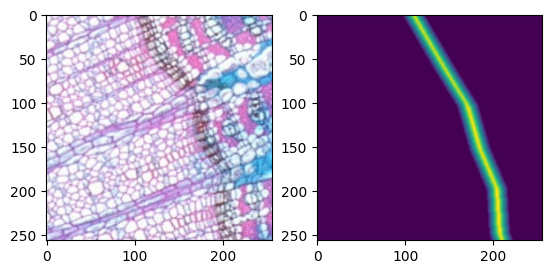

In [8]:
import matplotlib.pyplot as plt
N = 3
for image, mask in train_dataset.shuffle(len(train_dataset)).take(N):
    print(image.shape)
    print(mask.shape)
    print(tf.reduce_max(image), tf.reduce_min(image))
    print(tf.reduce_max(mask), tf.reduce_min(mask))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax2.imshow(mask[:, :, 0])
    plt.show()

Building blocks for the UNet.

Function that builds the UNet

Build the UNet.

In [1]:
from tree_ring_analyzer.dl.model import AttentionUnet
unet_model = AttentionUnet(filter=7, activation='linear').model

2025-04-02 14:39:34.067464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 14:39:34.075778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 14:39:34.078222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1743597576.793750   23033 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743597576.815122   23033 cuda_executor.cc:1015] succ

In [2]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        196 │ input_layer[0][0] │
│                     │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │        448 │ conv2d[0][0]      │
│                     │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        896 │ dropout[0][0]     │
│                     │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      1,778 │ conv2d_2[0][0]    │
│                     │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      3,556 │ dropout_1[0][0]   │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      7,084 │ conv2d_4[0][0]    │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     14,168 │ dropout_2[0][0]   │
│                     │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     28,280 │ conv2d_6[0][0]    │
│                     │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_3[

 Total params: 527,332 (2.01 MB)

 Trainable params: 526,912 (2.01 MB)

 Non-trainable params: 420 (1.64 KB)

Alternatively build the unet from the predifined keras models.

Define a loss function that is a weighted sum of dice and binary cross entropy.

Create an image of the UNet architecture.

In [17]:
keras.utils.plot_model(unet_model, show_shapes=True)
"model.png written"

You must install pydot (`pip install pydot`) for `plot_model` to work.


'model.png written'

Compile the model.

In [14]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['accuracy', 'precision', 'recall', 'mse'])

Train the model.

In [15]:
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',  # Filename
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only if it improves
    mode='min',  # Minimize the loss
    verbose=1
)

checkpoint_callback1 = ModelCheckpoint(
    'best_model.keras',  # Filename
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only if it improves
    mode='min',  # Minimize the loss
    verbose=1
)

NUM_EPOCHS = 100
keras.config.disable_traceback_filtering()
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
VAL_SUBSPLITS = 5
VAL_LENGTH = VALIDATION_SIZE
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=validation_batches, 
                              verbose=2,
                              callbacks=[checkpoint_callback, checkpoint_callback1]
                              )

Epoch 1/100


I0000 00:00:1743515673.886355  311537 service.cc:146] XLA service 0x778390047720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743515673.886376  311537 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation Laptop GPU, Compute Capability 8.9
I0000 00:00:1743515682.684640  311537 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 2.92267, saving model to best_model.h5



Epoch 1: val_loss improved from inf to 2.92267, saving model to best_model.keras
1346/1346 - 65s - 48ms/step - accuracy: 0.7721 - loss: 2.5927 - mse: 2.5927 - precision: 0.1972 - recall: 0.5923 - val_accuracy: 0.8071 - val_loss: 2.9227 - val_mse: 2.9227 - val_precision: 0.1867 - val_recall: 0.3992
Epoch 2/100


KeyboardInterrupt: 

Save a model.

In [18]:
import datetime
date = datetime.datetime.now()
unet_model.save(os.path.join(model_path, str(date) + ".keras"))

Save the weights only.

In [19]:
import datetime
date = datetime.datetime.now()
unet_model.save(os.path.join(model_path,  str(date) + ".h5"))

In [16]:
import json
json.dump(model_history.history, open('/home/khietdang/Documents/khiet/tree-ring-analyzer/src/history/bigDistance2.json', 'w'))

In [18]:
print(model_history.history.keys())

dict_keys(['accuracy', 'loss', 'mse', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_mse', 'val_precision', 'val_recall'])


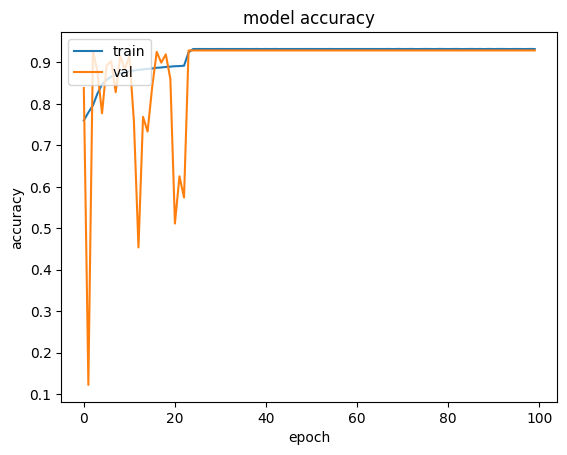

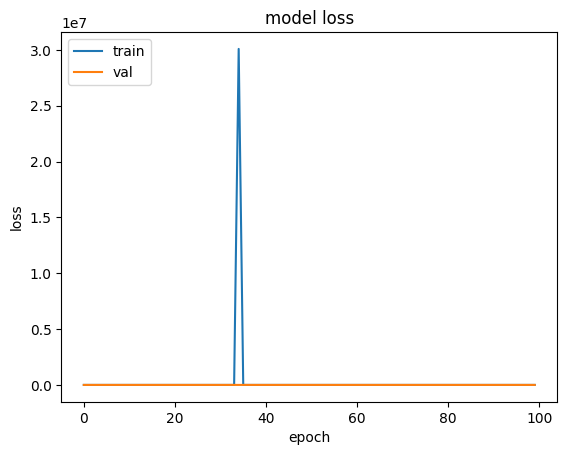

In [17]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load a saved model

In [21]:
model = "2025-03-10 08:15:16.877547.keras"
path = os.path.join(model_path, model)
unet_model = keras.models.load_model(path)

Load the weights only.

In [48]:
model = '2025-03-06 14:41:50.401830.weights.h5'
path = os.path.join(model_path, model)
unet_model.load_weights(path)

Evaluate model on test data.

In [49]:
test_batches = train_dataset.take(len(test_dataset)).batch(BATCH_SIZE)
score = unet_model.evaluate(test_batches, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6888464689254761
Test accuracy: 0.0
